In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 8.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from arch.unitroot import ADF
import statsmodels.api as sm
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#建構配對交易類別
class pair_trading:
  def adf(price_x, price_y, start, end):
    if price_x is None or price_y is None:
      print('缺少價格序列')
    price_x = price_x[start:end]
    price_y = price_y[start:end]
    price_x = np.log(price_x).diff()[1:]
    price_y = np.log(price_y).diff()[1:]
    adf_x = ADF(price_x)
    adf_y = ADF(price_y)
    print(adf_x.summary)
    print(adf_y.summary)
  def cointeration(price_x, price_y, start, end):
    if price_x is None or price_y is None:
      print('缺少價格序列')
    price_x = price_x[start:end]
    price_y = price_y[start:end]
    price_x = np.log(price_x)
    price_y = np.log(price_y)
    result = sm.OLS(price_y, sm.add_constant(price_x)).fit()
    resid = result.resid
    resid.plot()
    adf = ADF(resid)
    if adf.pvalue >= 0.05:
      print('交易不具共整合關係')
      print(f'P-value: {adf.pvalue}')
      print(f'Alpha: {result.params[0]}')
      print(f'Beta: {result.params[1]}')
      return None, None
    else:
      print('交易具共整合關係')
      print(f'P-value: {adf.pvalue}')
      print(f'Alpha: {result.params[0]}')
      print(f'Beta: {result.params[1]}')
      return result.params[0], result.params[1]
  def trade_signal(price_x, price_y, alpha, beta, start, end, test_start, test_end, multiplier, stop):
    if price_x is None or price_y is None:
      print('缺少價格序列')
    price_x = price_x[start:test_end]
    price_y = price_y[start:test_end]
    price_x = np.log(price_x)
    price_y = np.log(price_y)
    spread = price_y - alpha - beta * price_x
    std = spread[start:end].std()
    print(std)
    level = (float('-inf'), -stop*std, -multiplier*std, 0, multiplier*std, stop*std, float('inf'))
    signal = pd.cut(spread[start:test_end], level, labels=False)
    print(level)
    return signal, spread
  def trade_account(price_x, price_y, signal, beta, spread, start, end, test_start, test_end, fund=1000000):
    position, number_x, number_y, interest_income = 0, 0, 0, 0
    equity = fund
    equitys, cum_return, buy, sell, offset = pd.Series(0.0, index=signal.index), pd.Series(0.0, index=signal.index), pd.Series(0.0, index=signal.index), pd.Series(0.0, index=signal.index), pd.Series(0.0, index=signal.index)
    equitys[signal.index[0]] = equity
    cum_return[signal.index[0]] = 1
    buy[signal.index[0]], sell[signal.index[0]], offset[signal.index[0]] = None, None, None
    tax = 0.003
    commision = 0.001425
    short_cost = 0.0008
    short_interest = 0.002
    slip = 0.005
    for i in range(0, len(signal.index)):
      today = signal.index[i].strftime('%Y-%m-%d')
      if today == end:
        if position == 1:
          open_x = price_x['開盤價(元)'][test_start]
          open_y = price_y['開盤價(元)'][test_start]
          equity = fund + number_x * open_x * (1 - commision - tax - slip) - number_y * open_y * (1 + commision + slip) + interest_income
          position, number_x, number_y, interest_income = 0, 0, 0, 0
          fund = equity
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[test_start] = equity
          cum_return[test_start] = cum_return[today] * (1 + ret)
          sell[test_start], buy[test_start], offset[test_start] = None, None, spread[next_date]
        elif position == -1:
          open_x = price_x['開盤價(元)'][test_start]
          open_y = price_y['開盤價(元)'][test_start]
          equity = fund + number_y * open_y * (1 - commision - tax - slip) - number_x * open_x * (1 + commision + slip) + interest_income
          position, number_x, number_y, interest_income = 0, 0, 0, 0
          fund = equity
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[test_start] = equity
          cum_return[test_start] = cum_return[today] * (1 + ret)
          sell[test_start], buy[test_start], offset[test_start] = None, None, spread[test_start]
        else:
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[test_start] = equity
          cum_return[test_start] = cum_return[today] * (1 + ret)
          sell[test_start], buy[test_start], offset[test_start] = None, None, None
      elif today == test_end:
        break
      else:
        next_date = signal.index[i+1].strftime('%Y-%m-%d')
        if position == 0 and signal[i] == 4:
          #print('buy x sell y')
          position = 1
          open_x = price_x['開盤價(元)'][next_date]
          open_y = price_y['開盤價(元)'][next_date]
          close_x = price_x['收盤價(元)'][next_date]
          close_y = price_y['收盤價(元)'][next_date]
          number_x = (fund * beta / (1 + beta)) // (open_x * (1 + commision + slip))
          number_y = (fund / (1 + beta)) // (open_y * (1 + commision + tax + short_cost + slip)) // 1000 * 1000
          fund = fund - number_x * open_x * (1 + commision + slip) + number_y * open_y * (1 - commision - tax - short_cost - slip)
          interest_income = open_y * 0.9 * short_interest / 365
          equity = fund + number_x * close_x * (1 - commision - tax - slip) - number_y * close_y * (1 + commision + slip) + interest_income
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[next_date] = equity
          cum_return[next_date] = cum_return[today] * (1 + ret)
          sell[next_date], buy[next_date], offset[next_date] = spread[next_date], None, None
        elif position == 1 and (signal[i] == 4 or signal[i] == 3):
          #print('hold1')
          close_x = price_x['收盤價(元)'][next_date]
          close_y = price_y['收盤價(元)'][next_date]
          equity = fund + number_x * close_x * (1 - commision - tax - slip) - number_y * close_y * (1 + commision + slip) + interest_income
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[next_date] = equity
          cum_return[next_date] = cum_return[today] * (1 + ret)
          sell[next_date], buy[next_date], offset[next_date] = None, None, None
        elif position == 0 and signal[i] == 1:
          #print('buy y sell x')
          position = -1
          open_x = price_x['開盤價(元)'][next_date]
          open_y = price_y['開盤價(元)'][next_date]
          close_x = price_x['收盤價(元)'][next_date]
          close_y = price_y['收盤價(元)'][next_date]
          number_y = (fund / (1 + beta)) // (open_y * (1 + commision + slip))
          number_x = (((fund * beta / (1 + beta)) // (open_x * (1 + commision + tax + short_cost + slip)))) // 1000 * 1000
          fund = fund - number_y * open_y * (1 + commision + slip) + number_x * open_x * (1 - commision - tax - short_cost - slip)
          interest_income = open_x * 0.9 * short_interest / 365
          equity = fund + number_y * close_y * (1 - commision - tax - slip) - number_x * close_x * (1 + commision + slip) + interest_income
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[next_date] = equity
          cum_return[next_date] = cum_return[today] * (1 + ret)
          sell[next_date], buy[next_date], offset[next_date] = None, spread[next_date], None
        elif position == -1 and (signal[i] == 1 or signal[i] == 2):
          #print('hold2')
          close_x = price_x['收盤價(元)'][next_date]
          close_y = price_y['收盤價(元)'][next_date]
          equity = fund + number_y * close_y * (1 - commision - tax - slip) - number_x * close_x * (1 + commision + slip) + interest_income
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[next_date] = equity
          cum_return[next_date] = cum_return[today] * (1 + ret)
          sell[next_date], buy[next_date], offset[next_date] = None, None, None
        elif position == 0 and (signal[i] == 3 or signal[i] == 2 or signal[i] == 0 or signal[i] == 5):
          #print('remain')
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[next_date] = equity
          cum_return[next_date] = cum_return[today] * (1 + ret)
          sell[next_date], buy[next_date], offset[next_date] = None, None, None
        elif position == 1 and (signal[i] == 2 or signal[i] == 1 or signal[i] == 5):
          #print('平倉1')
          position = 0
          open_x = price_x['開盤價(元)'][next_date]
          open_y = price_y['開盤價(元)'][next_date]
          equity = fund + number_x * open_x * (1 - commision - tax - slip) - number_y * open_y * (1 + commision + slip) + interest_income
          fund = equity
          interest_income = 0
          number_x = 0
          number_y = 0
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[next_date] = equity
          cum_return[next_date] = cum_return[today] * (1 + ret)
          sell[next_date], buy[next_date], offset[next_date] = None, None, spread[next_date]
        elif position == -1 and (signal[i] == 3 or signal[i] == 4 or signal[i] == 0):
          #print('平倉2')
          position = 0
          open_x = price_x['開盤價(元)'][next_date]
          open_y = price_y['開盤價(元)'][next_date]
          equity = fund + number_y * open_y * (1 - commision - tax - slip) - number_x * open_x * (1 + commision + slip) + interest_income
          fund = equity
          interest_income = 0
          number_x = 0
          number_y = 0
          ret = equity / equitys[today] - 1 #計算報酬
          equitys[next_date] = equity
          cum_return[next_date] = cum_return[today] * (1 + ret)
          sell[next_date], buy[next_date], offset[next_date] = None, None, spread[next_date]
    return cum_return, equitys, buy, sell, offset
  def perform(cum_return, equitys, spread, buy, sell, offset, year, year_test):
    spread.plot(label='spread')
    buy.plot(label='buy', style='o', markersize=5)
    sell.plot(label='sell', style='o', markersize=5)
    offset.plot(label='offset', style='o', markersize=5)
    plt.legend()
    plt.ylabel('spread')
    plt.xlabel('Date')
    plt.title('spread & signal', fontsize=16)
    plt.show()
    equitys.plot()
    plt.axvline(x='2023-01-03', color='black')
    plt.show()
    #全部
    cum_return_total = cum_return
    cum_return_total = (cum_return_total - 1) * 100
    MDD_series = cum_return_total.cummax() - cum_return_total
    high_index = cum_return_total[cum_return_total.cummax() == cum_return_total].index
    fig, ax = plt.subplots(figsize=(16,6))
    cum_return_total.plot(label='Cumulative Return', ax=ax, c='r')
    plt.fill_between(MDD_series.index, -MDD_series, 0, facecolor='r', label='DD')
    plt.scatter(high_index, cum_return_total.loc[high_index], c='#02ff0f', label='High')
    plt.axvline(x=test_start, color='blue', linestyle='--')
    plt.legend()
    plt.ylabel('Return%')
    plt.xlabel('Date')
    plt.title('Return & MDD', fontsize=16)
    plt.show()
    #樣本內
    cum_return_in = cum_return[start:end]
    daily_return = cum_return_in.diff(1)
    annual_return = cum_return_in.iloc[-1] ** (1 / year) - 1
    print(daily_return.std())
    annual_std = daily_return.std() * (240 ** 0.5)
    print(f'年化報酬率: {round(annual_return * 100, 2)}%') #年化報酬
    print(f'累積報酬率: {round((cum_return_in.iloc[-1] - 1) * 100, 2)}%') #累積報酬
    print(f'年化波動度: {round(annual_std * 100, 2)}%')
    print(f'年化夏普值: {round(annual_return / annual_std, 2)}')
    #最大回徹圖
    cum_return_in = (cum_return_in - 1) * 100
    MDD_series = cum_return_in.cummax() - cum_return_in
    MDD = round(MDD_series.max(), 2)
    print(f'MDD(%): {MDD}%')
    print(f'風報比: {round(cum_return_in.iloc[-1] / MDD, 2)}')
    print(f'{round(annual_return * 100, 2)}%', f'{round(annual_return / annual_std, 2)}', f'{MDD}%', f'{round(cum_return_in.iloc[-1] / MDD, 2)}')
    high_index = cum_return_in[cum_return_in.cummax() == cum_return_in].index
    fig, ax = plt.subplots(figsize=(16,6))
    cum_return_in.plot(label='Cumulative Return', ax=ax, c='r')
    plt.fill_between(MDD_series.index, -MDD_series, 0, facecolor='r', label='DD')
    plt.scatter(high_index, cum_return_in.loc[high_index], c='#02ff0f', label='High')
    plt.legend()
    plt.ylabel('Return%')
    plt.xlabel('Date')
    plt.title('Return & MDD', fontsize=16)
    plt.show()
    #樣本外
    cum_return_out = cum_return[test_start:test_end]
    cum_return_out = cum_return_out / cum_return_out[test_start]
    daily_return = cum_return_out.diff(1)
    annual_return = cum_return_out.iloc[-1] ** (1 / year_test) - 1
    annual_std = daily_return.std() * ((240 * year_test) ** 0.5)
    print(f'年化報酬率: {round(annual_return * 100, 2)}%') #年化報酬
    print(f'累積報酬率: {round((cum_return_out.iloc[-1] - 1) * 100, 2)}%') #累積報酬
    print(f'年化波動度: {round(annual_std * 100, 2)}%')
    print(f'年化夏普值: {round(annual_return / annual_std, 2)}')
    #最大回徹圖
    cum_return_out = (cum_return_out - 1) * 100
    MDD_series = cum_return_out.cummax() - cum_return_out
    MDD = round(MDD_series.max(),2)
    print(f'MDD(%): {MDD}%')
    print(f'風報比: {round(cum_return_out.iloc[-1] / MDD, 2)}')
    print(f'{round(annual_return * 100, 2)}%', f'{round(annual_return / annual_std, 2)}', f'{MDD}%', f'{round(cum_return_out.iloc[-1] / MDD, 2)}')
    high_index = cum_return_out[cum_return_out.cummax() == cum_return_out].index
    fig, ax = plt.subplots(figsize=(16,6))
    cum_return_out.plot(label='Cumulative Return', ax=ax, c='r')
    plt.fill_between(MDD_series.index, -MDD_series, 0, facecolor='r', label='DD')
    plt.scatter(high_index, cum_return_out.loc[high_index], c='#02ff0f', label='High')
    plt.legend()
    plt.ylabel('Return%')
    plt.xlabel('Date')
    plt.title('Return & MDD', fontsize=16)
    plt.show()


In [111]:
price_x = pd.read_csv("/content/drive/MyDrive/stock_price/9921.csv", index_col='年月日') #讀取 中華 股價 2204
price_x.index = pd.to_datetime(price_x.index)
price_y = pd.read_csv("/content/drive/MyDrive/stock_price/9914.csv", index_col='年月日') #讀取 和泰車 股價 2207
price_y.index = pd.to_datetime(price_y.index)
start = '2019-01-02' #形成期起始日期
end = '2022-12-30' #形成期結束日期
test_start = '2023-01-03' #交易期起始日期
test_end = '2023-12-29' #交易期結束日期
multiplier = 1.5 #標準差倍數，
stop = 100
year = 4
year_test = 1

交易具共整合關係
P-value: 0.008426439710706233
Alpha: -0.7804404450463645
Beta: 1.126406507728243


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: Us

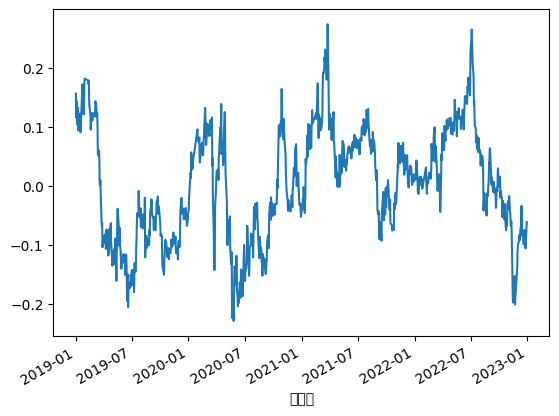

In [112]:
#做共整合檢定
alpha, beta = pair_trading.cointeration(price_x['收盤價(元)'], price_y['收盤價(元)'], start, end)

In [113]:
#建構配對交易策略
signal, spread = pair_trading.trade_signal(price_x['收盤價(元)'], price_y['收盤價(元)'], alpha, beta, start, end, test_start, test_end, multiplier, stop)

0.09500813680837007
(-inf, -9.500813680837007, -0.14251220521255512, 0, 0.14251220521255512, 9.500813680837007, inf)


In [114]:
#樣本內
fund = 10000000
cum_return, equitys, buy, sell, offset = pair_trading.trade_account(price_x, price_y, signal, beta, spread, start, end, test_start, test_end, fund)

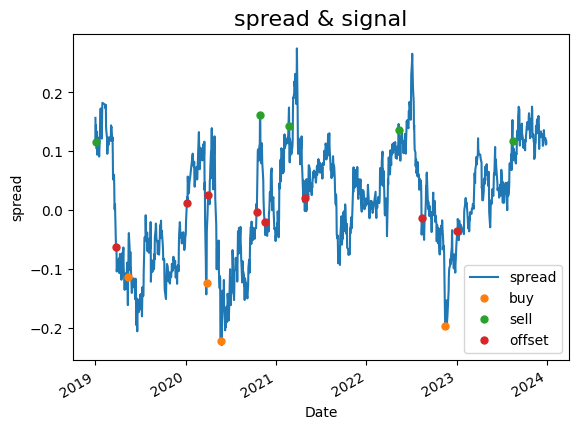

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


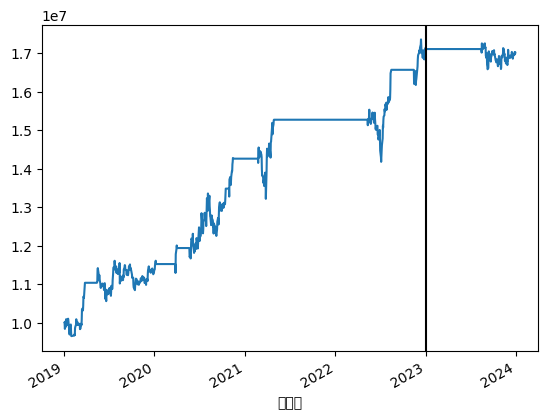

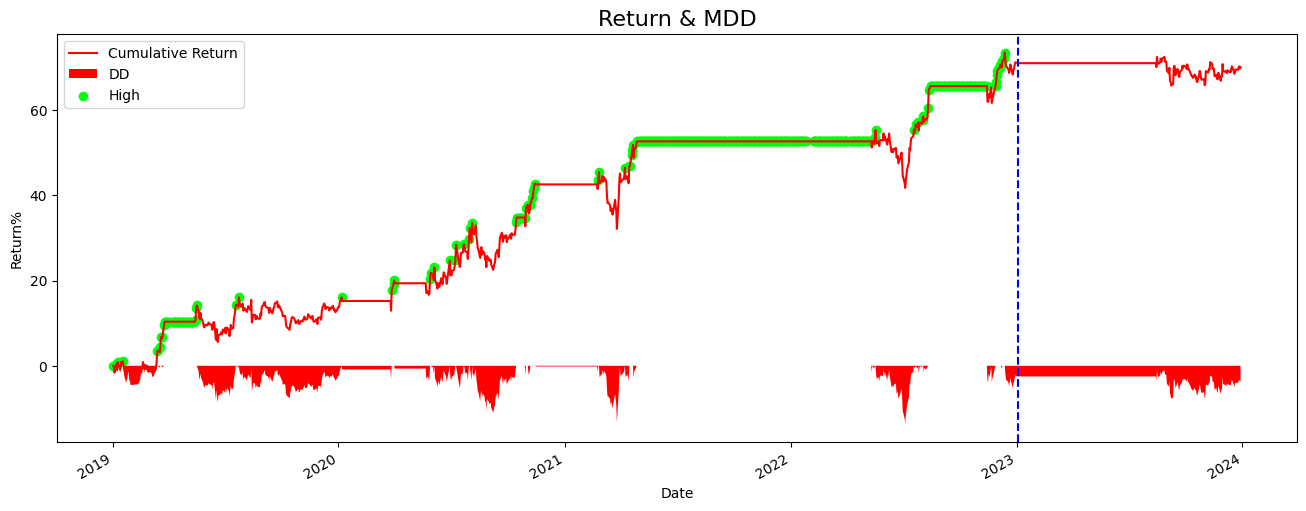

0.010031066332045358
年化報酬率: 14.4%
累積報酬率: 71.26%
年化波動度: 15.54%
年化夏普值: 0.93
MDD(%): 13.54%
風報比: 5.26
14.4% 0.93 13.54% 5.26


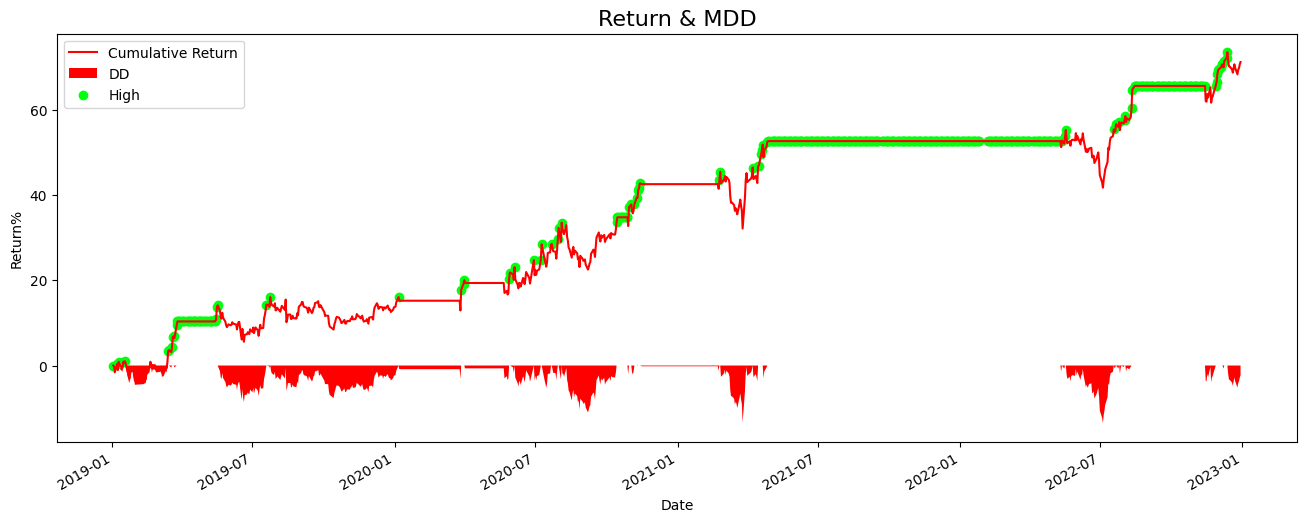

年化報酬率: -0.56%
累積報酬率: -0.56%
年化波動度: 6.14%
年化夏普值: -0.09
MDD(%): 3.94%
風報比: -0.14
-0.56% -0.09 3.94% -0.14


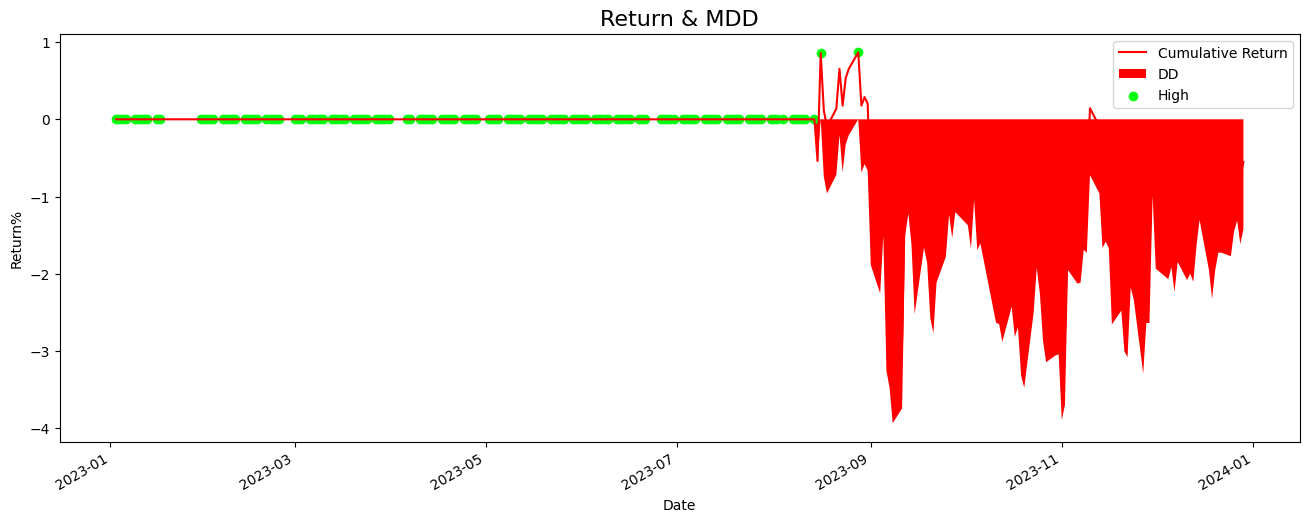

In [115]:
#樣本內績效
pair_trading.perform(cum_return, equitys, spread, buy, sell, offset, year, year_test)

In [116]:
#大盤績效
tw_index = pd.read_csv("/content/drive/MyDrive/stock_price/9999.csv", index_col='年月日')
tw_index = tw_index['收盤價(元)']
tw_index.index = pd.to_datetime(tw_index.index)
#樣本內
cum_return_in = tw_index[start:end] / tw_index[start]
daily_return = cum_return_in.diff(1)
annual_return = cum_return_in.iloc[-1] ** 0.25 - 1
annual_std = daily_return.std() * (240 ** 0.5)
print(f'年化報酬率: {round(annual_return * 100, 2)}%') #年化報酬
print(f'累積報酬率: {round((cum_return_in.iloc[-1] - 1) * 100, 2)}%') #累積報酬
print(f'年化波動度: {round(annual_std * 100, 2)}%')
print(f'年化夏普值: {round(annual_return / annual_std, 2)}')
#最大回徹
cum_return_in = (cum_return_in - 1) * 100
MDD_series = cum_return_in.cummax() - cum_return_in
MDD = round(MDD_series.max(), 2)
print(f'MDD(%): {MDD}%')
print(f'風報比: {round(cum_return_in.iloc[-1] / MDD, 2)}')
#樣本外
cum_return_out = tw_index[test_start:test_end] / tw_index[test_start]
daily_return = cum_return_out.diff(1)
annual_return = cum_return_out.iloc[-1] - 1
annual_std = daily_return.std() * (240 ** 0.5)
print(f'年化報酬率: {round(annual_return * 100, 2)}%') #年化報酬
print(f'累積報酬率: {round((cum_return_out.iloc[-1] - 1) * 100, 2)}%') #累積報酬
print(f'年化波動度: {round(annual_std * 100, 2)}%')
print(f'年化夏普值: {round(annual_return / annual_std, 2)}')
#最大回徹
cum_return_out = (cum_return_out - 1) * 100
MDD_series = cum_return_out.cummax() - cum_return_out
MDD = round(MDD_series.max(), 2)
print(f'MDD(%): {MDD}%')
print(f'風報比: {round(cum_return_out.iloc[-1] / MDD, 2)}')

年化報酬率: 10.29%
累積報酬率: 47.97%
年化波動度: 25.13%
年化夏普值: 0.41
MDD(%): 61.34%
風報比: 0.78
年化報酬率: 26.06%
累積報酬率: 26.06%
年化波動度: 13.88%
年化夏普值: 1.88
MDD(%): 9.38%
風報比: 2.78


In [117]:
'''#建立投組
stock_pool = [[1476, 1434], [2204, 2207], [3481, 2409], [2002, 2014], [9921, 9914]]
price_x1 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[0][0]}.csv", index_col='年月日')
price_x1.index = pd.to_datetime(price_x.index)
price_y1 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[0][1]}.csv", index_col='年月日')
price_y1.index = pd.to_datetime(price_y.index)

price_x2 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[1][0]}.csv", index_col='年月日')
price_x2.index = pd.to_datetime(price_x.index)
price_y2 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[1][1]}.csv", index_col='年月日')
price_y2.index = pd.to_datetime(price_y.index)

price_x3 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[2][0]}.csv", index_col='年月日')
price_x3.index = pd.to_datetime(price_x.index)
price_y3 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[2][1]}.csv", index_col='年月日')
price_y3.index = pd.to_datetime(price_y.index)

price_x4 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[3][0]}.csv", index_col='年月日')
price_x4.index = pd.to_datetime(price_x.index)
price_y4 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[3][1]}.csv", index_col='年月日')
price_y4.index = pd.to_datetime(price_y.index)

price_x5 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[4][0]}.csv", index_col='年月日')
price_x5.index = pd.to_datetime(price_x.index)
price_y5 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[4][1]}.csv", index_col='年月日')
price_y5.index = pd.to_datetime(price_y.index)

start = '2019-01-02'
end = '2022-12-30'
test_start = '2023-01-03'
test_end = '2023-12-29'
multiplier = 2
stop = 2.5
fund = 1000000'''

'#建立投組\nstock_pool = [[1476, 1434], [2204, 2207], [3481, 2409], [2002, 2014], [9921, 9914]]\nprice_x1 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[0][0]}.csv", index_col=\'年月日\')\nprice_x1.index = pd.to_datetime(price_x.index)\nprice_y1 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[0][1]}.csv", index_col=\'年月日\')\nprice_y1.index = pd.to_datetime(price_y.index)\n\nprice_x2 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[1][0]}.csv", index_col=\'年月日\')\nprice_x2.index = pd.to_datetime(price_x.index)\nprice_y2 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[1][1]}.csv", index_col=\'年月日\')\nprice_y2.index = pd.to_datetime(price_y.index)\n\nprice_x3 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[2][0]}.csv", index_col=\'年月日\')\nprice_x3.index = pd.to_datetime(price_x.index)\nprice_y3 = pd.read_csv(f"/content/drive/MyDrive/stock_price/{stock_pool[2][1]}.csv", index_col=\'年月日\')\nprice_y3.index = pd.to_datetime(p